# Perspectives on Utilization of Measurements in Quantum Algorithms
<center>
<div style="font-family: Georgia, serif; margin: 1em 0;">
  <ul style="list-style-type: none; padding: 0;">
    <li style="margin: 0.2em 0; font-size: 1.2em;">Valter Uotila, Ilmo Salmenperä,</li>
    <li style="margin: 0.2em 0; font-size: 1.2em;">Leo Becker, Arianne Meijer-van de Griend,</li>
      <li style="margin: 0.2em 0; font-size: 1.2em;">Aakash Ravindra Shinde, Jukka K. Nurminen</li>
  </ul>
</div>
</center>

<center>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/8/84/University_of_Helsinki.svg/1280px-University_of_Helsinki.svg.png" alt="HY-logo" width="200" height="200">
</center>

## Outline of the presentation

1. Introduction and motivation
2. Categories for measurement operations with code examples
   1. Measurements in static quantum circuits (Code demo: Recovering a density matrix)
   2. Measurements in dynamic quantum circuits (Code demo: Toffoli gate teleportation)
   3. Measurements as solutions to challenges in NISQ devices
3. Conclusion

## Motivation

1. Making measurements as an active part of the algorithm rather than a passive readout method might improve the performance of our quantum algorithms and tackle problems such as integration with classical systems, scalability and error.
2. Measurements are not necessarily the key contribution in many papers, although many algorithms utilize clever measurement schemes. Building a ''measurement toolbox'' might help us choose the best measurement scheme for algorithms or try something new.
3. There are no previous works which would survey the role of measurements in practical quantum algorithms and emphasize their key role in the algorithms

## Scope
This paper contains only a subset of measurement operation use cases. For example, we left out:
1. Error-correcting codes$^1$
2. Measurement-based quantum computing$^2$
3. Quantum metrology$^3$

* $^1$ *Fault-tolerant quantum computation*. Peter W. Shor.
* $^2$ *An introduction to measurement based quantum computation*. Richard Jozsa.
* $^3$ *A variational toolbox for quantum multi-parameter estimation* J.J.

## Introduction


| **Measurement theory**     | **Properties**                                                                                                                                         | **Quantum states** | **Properties**                                                                                      |
|---------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|------------------------------------------------------------------------------------------------------|
| **PVM measurements**      | Idempotent: $P_i^2 = P_i$  <br> Orthogonality: $P_i P_j = \delta_{ij}P_i$ <br> Completeness: $\sum_i P_i = I$                                            | **Pure states**    | Idempotent: $\rho^2 = \rho$ <br> Projection onto 1D subspace <br> Normalization: $\text{Tr}(\rho) = 1$ |
| **POVM measurements**     | Positive operators $E_i \geq 0$ <br> Completeness: $\sum_i E_i = I$ <br> Not necessarily orthogonal <br> Generalization of PVMs                          | **Mixed states**   | Positive operators $\rho \geq 0$ <br> Normalization: $\text{Tr}(\rho) = 1$ <br> Not necessarily pure <br> Generalization of pure states |

## Category 1: Measurements in static quantum circuits

Measure the whole state so that the measurement outcomes do not affect the current circuit execution.

1. Fundamental quantum algorithms$^1$
2. Variational quantum computing$^2$
   1. Quantum optimization: optimization problems are measurements
   2. Quantum machine learning: global observables lead to barren plateaus$^3$
   3. Quantum machine learning: measurements are a source of non-linearity
3. Classical machine learning for measurement optimization$^4$

* $^1$ https://quantumalgorithmzoo.org/. Stephen P. Jordan.
* $^2$ *Variational quantum algorithms*. M. Cerezo et al.
* $^3$ *A Lie Algebraic Theory of Barren Plateaus for Deep Parameterized Quantum Circuits*. M. Ragone et al.
* $^4$ *Learning to Measure: Adaptive Informationally Complete Generalized Measurements for Quantum Algorithms*. G García-Pérez et al.

## Demonstration on Informationally Complete Positive-Valued Operator Measures (IC-POVM)$^1$

Consider the following set of POVMs
\begin{align}
    E_{+z} &= p_z |0\rangle\langle0|, &\quad E_{-z} &= p_z |1\rangle\langle1|, \\
    E_{\pm x} &= p_x | \pm \rangle \langle \pm |, &\quad E_{\pm y} &= p_y | \pm i \rangle \langle \pm i |,
\end{align}
where $p_{z}, p_{x}, p_{y} \in [0, 1]$ so that $p_{z} + p_{x} + p_{y} = 1$.

* $^1$ *Scalable tensor-network error mitigation for near-term quantum computing*. S. Filippov et al.

The reconstruction of the state is done with so-called dual operators, which are given by
\begin{align}
    D_{\pm \alpha} = \frac{I \pm \sigma_{\alpha}/p_{\alpha}}{2},
\end{align}
where $\sigma_{\alpha}$ is the corresponding Pauli matrix, $p_{\alpha}$ is the probability and $\alpha \in \left\{x, y, z \right\}$.

With the dual operators, the reconstructed state $\rho$ has the following form
\begin{align}
    \rho = \sum_{k \in I} \mathrm{Tr}(\rho E_k) D_k.
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

from qiskit_aer import Aer

backend = Aer.get_backend('statevector_simulator')

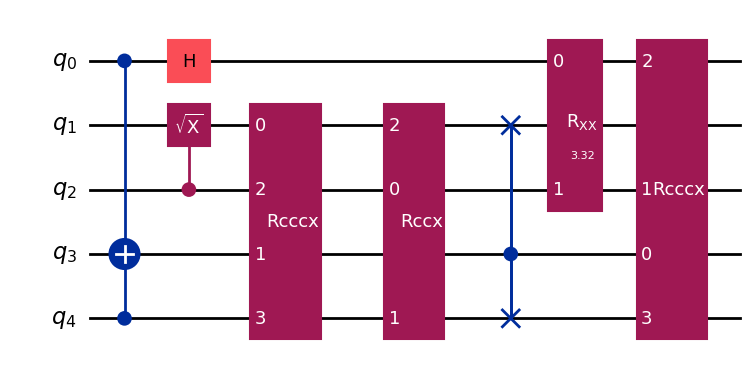

In [2]:
from qiskit.circuit.random import random_circuit

n_qubits = 5
circuit = random_circuit(n_qubits, 5, measure=False)
fig = circuit.draw(output='mpl')
plt.show()

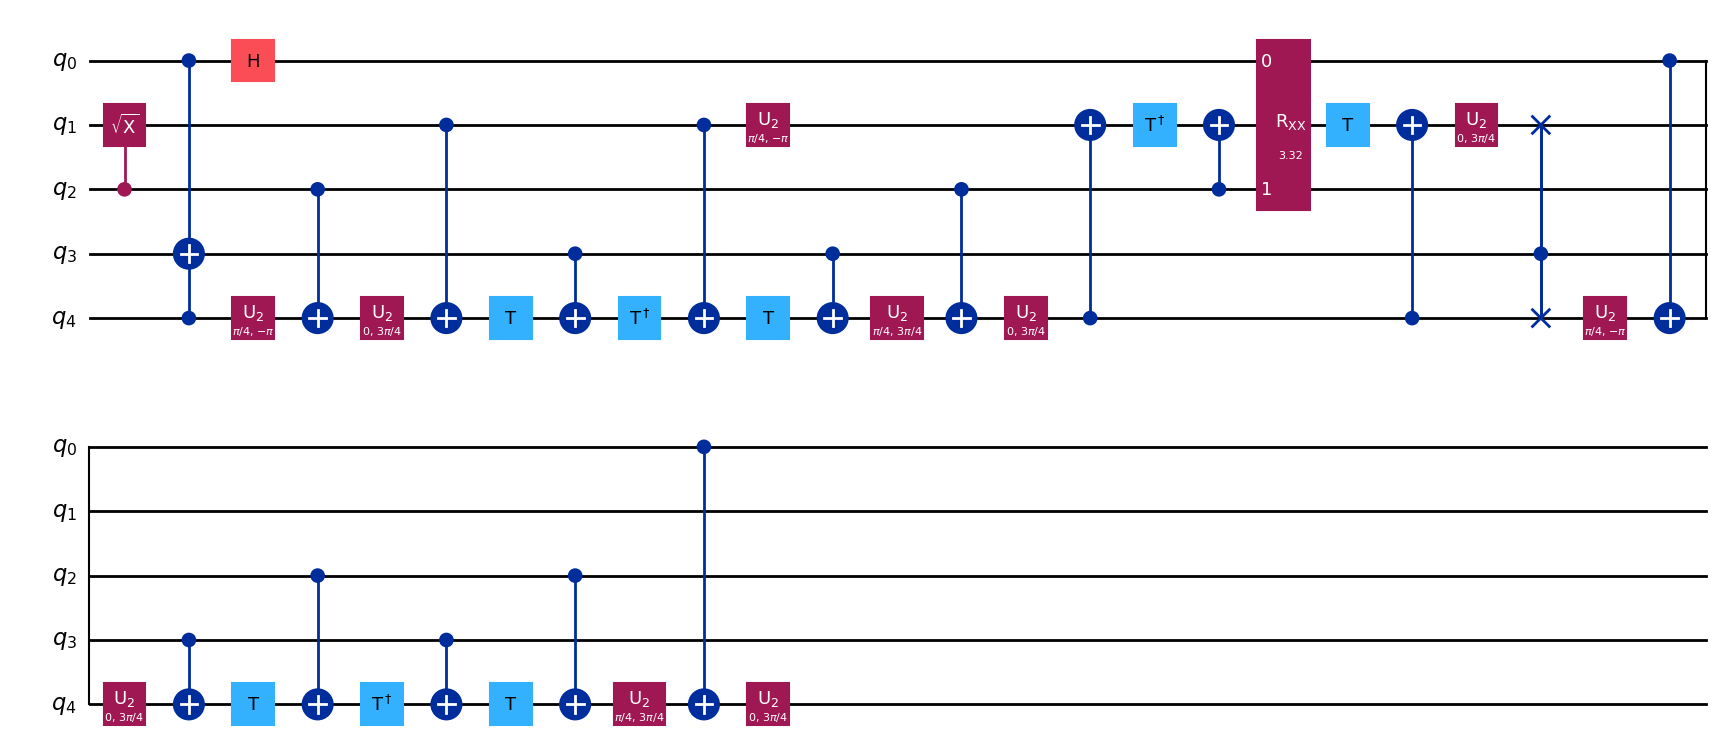

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
transpiled_circuit = pass_manager.run(circuit)
fig = transpiled_circuit.draw(output='mpl')
plt.show()

In [4]:
from povm_toolbox.sampler import POVMSampler 
from povm_toolbox.library import ClassicalShadows
from povm_toolbox.post_processor import POVMPostProcessor

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
povm_sampler = POVMSampler(sampler=sampler)
measurement = ClassicalShadows(num_qubits=n_qubits, seed=0)
shots =  2000
job = povm_sampler.run([circuit], shots=shots, povm=measurement, pass_manager=pass_manager)
pub_result = job.result()[0]
counts = pub_result.get_counts()

observable = SparsePauliOp.from_list([("ZIIII", 1), ("IZIII", 1), ("IIZII", 1), ("IIIZI", 1), ("IIIIZ", 1)])

post_processor = POVMPostProcessor(pub_result)
exp_value, std= post_processor.get_expectation_value(observable)
print("Noisy expectation value: ", exp_value)

Noisy expectation value:  2.0084999999999997


In [5]:
from qiskit.quantum_info import Statevector

statevector = Statevector.from_instruction(circuit)

# Compute the exact expectation value
expectation_value = statevector.expectation_value(observable)
print("Expectation value:", expectation_value.real)

Expectation value: 2.016579692739088


In [6]:
probabilities = {}
for res, count in counts.items():
   c = tuple((int(r) for r in res))
   probabilities[c] = count / shots

In [7]:
from qiskit.quantum_info import Operator, DensityMatrix
from functools import reduce

density_matrix = None

for state, prob in probabilities.items():
    duals = [post_processor.dual[(qubit_id,)].operators[povm_id] for qubit_id, povm_id in enumerate(reversed(state))]
    
    # Convert to Qiskit Operators
    dual_operators = [Operator(dual) for dual in duals]
    
    # Compute tensor product
    tensor_product_op = reduce(lambda a, b: a.tensor(b), dual_operators)
    
    # Scale and add
    if density_matrix is None:
        density_matrix = prob * tensor_product_op
    else:
        density_matrix = density_matrix + prob * tensor_product_op

density_matrix = DensityMatrix(density_matrix.data)

# Compute expectation value
expectation_value = density_matrix.expectation_value(observable)
print(f"Expectation value: {expectation_value.real}")

Expectation value: 2.008500000000006


In [8]:
from utils import visualize_density_matrix

# Use the enhanced visualization
#visualize_density_matrix(density_matrix, n_qubits)

## Category 2: Measurements in dynamic quantum circuits

Dynamic quantum circuits modify the quantum state during the computation via mid-circuit measurements

In the paper, we discuss:
1. State preparation$^1$
2. State and gate teleportation$^2$

* $^1$ *Experimental demonstration of the advantage of adaptive quantum circuits*. M. Foss-Feig et al.
* $^2$ *Demonstrating the viability of universal quantum computation using teleportation and single-qubit operations*. D. Gottesman, I. L. Chuang.

## Toffoli gate teleportation$^1$

Gate teleportation generally:

<center>
<img src="figures/gate_teleportation.png" alt="gate_teleportation" width="800">
</center>

* $^1$ Gate Teleportation in Noisy Quantum Networks with the SquidASM Simulator. V. Uotila.

In [9]:
import pennylane as qml
import numpy as np

# Get matrix for toffoli gate
def get_toffoli_matrix():
    return np.array(qml.Toffoli(wires=[0,1,2]).matrix())

X0, X1, X2 = qml.PauliX(0), qml.PauliX(1), qml.PauliX(2)
Z0, Z1, Z2 = qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)
I0, I1, I2 = qml.Identity(0), qml.Identity(1), qml.Identity(2)

basis = [Z0 @ I1 @ I2, 
        I0 @ Z1 @ I2,
        I0 @ I1 @ Z2,
        X0 @ I1 @ I2,
        I0 @ X1 @ I2,
        I0 @ I1 @ X2]

results = []
for b in basis:
    results.append(get_toffoli_matrix() @ b.matrix() @ get_toffoli_matrix())
    
pauli_decomposed = []

for result in results:
    pauli_decomposed.append(qml.pauli_decompose(result, wire_order=[6, 7, 8]))

for p in pauli_decomposed:
    print(p.coeffs, p.ops)

[1.] [Z(6) @ I(7) @ I(8)]
[1.] [I(6) @ Z(7) @ I(8)]
[ 0.5  0.5  0.5 -0.5] [I(6) @ I(7) @ Z(8), I(6) @ Z(7) @ Z(8), Z(6) @ I(7) @ Z(8), Z(6) @ Z(7) @ Z(8)]
[ 0.5  0.5  0.5 -0.5] [X(6) @ I(7) @ I(8), X(6) @ I(7) @ X(8), X(6) @ Z(7) @ I(8), X(6) @ Z(7) @ X(8)]
[ 0.5  0.5  0.5 -0.5] [I(6) @ X(7) @ I(8), I(6) @ X(7) @ X(8), Z(6) @ X(7) @ I(8), Z(6) @ X(7) @ X(8)]
[1.] [I(6) @ I(7) @ X(8)]


(<Figure size 1500x400 with 1 Axes>, <Axes: >)

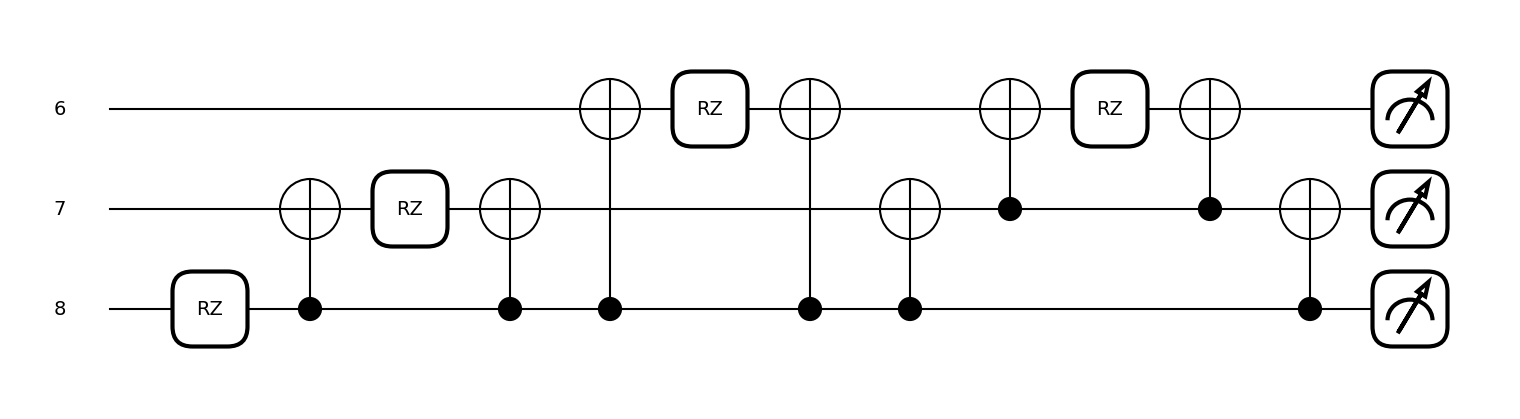

In [10]:
from utils import controlled_circuit1, controlled_circuit2, controlled_circuit3, controlled_circuit4, controlled_circuit5
dev = qml.device("default.qubit", wires=[6, 7, 8])
# To visualize and debug the circuits
@qml.qnode(dev)
def circuit2():
    controlled_circuit2(np.pi/2)
    return qml.sample()

qml.draw_mpl(circuit2)()

In [11]:
dev = qml.device("default.qubit", wires=[0, 1, 2, 3, 4, 5, 6, 7, 8])
values = np.random.rand(9)

def bell_pair(source, target):
    qml.Hadamard(wires=source)
    qml.CNOT(wires=[source, target])
    
def bell_measurement(source, target):
    qml.CNOT(wires=[source, target])
    qml.Hadamard(wires=source)

In [12]:
@qml.qnode(dev)
def toffoli_teleportation():
    # Prepare the random input state for Toffoli gate
    
    qml.Rot(values[0], values[1], values[2], wires=0)
    qml.Rot(values[3], values[4], values[5], wires=1)
    qml.Rot(values[6], values[7], values[8], wires=2)
    
    # Prepare Bell pairs
    bell_pair(3, 6)
    bell_pair(4, 7)
    bell_pair(5, 8)
    
    #Prepare the Bell measurement
    bell_measurement(0, 3)
    bell_measurement(1, 4)
    bell_measurement(2, 5)
    
    # Perform the Toffoli gate on the output qubits
    qml.Toffoli(wires=[6, 7, 8])
    
    # Perform the Bell measurement
    m0 = qml.measure([0], reset=True)
    m1 = qml.measure([1], reset=True)
    m2 = qml.measure([2], reset=True)
    a0 = qml.measure([3], reset=True)
    a1 = qml.measure([4], reset=True)
    a2 = qml.measure([5], reset=True)
    
    glob_coeff = np.pi/2
    qml.cond(m0, controlled_circuit1)([6], coeff=2*glob_coeff)
    qml.cond(m1, controlled_circuit1)([7], coeff=2*glob_coeff)
    qml.cond(m2, controlled_circuit2)(coeff=glob_coeff)
    qml.cond(a0, controlled_circuit3)(coeff=glob_coeff)
    qml.cond(a1, controlled_circuit4)(coeff=glob_coeff)
    qml.cond(a2, controlled_circuit5)(coeff=2*glob_coeff)
    
    return qml.density_matrix(wires=[6, 7, 8])

(<Figure size 7200x1200 with 1 Axes>, <Axes: >)

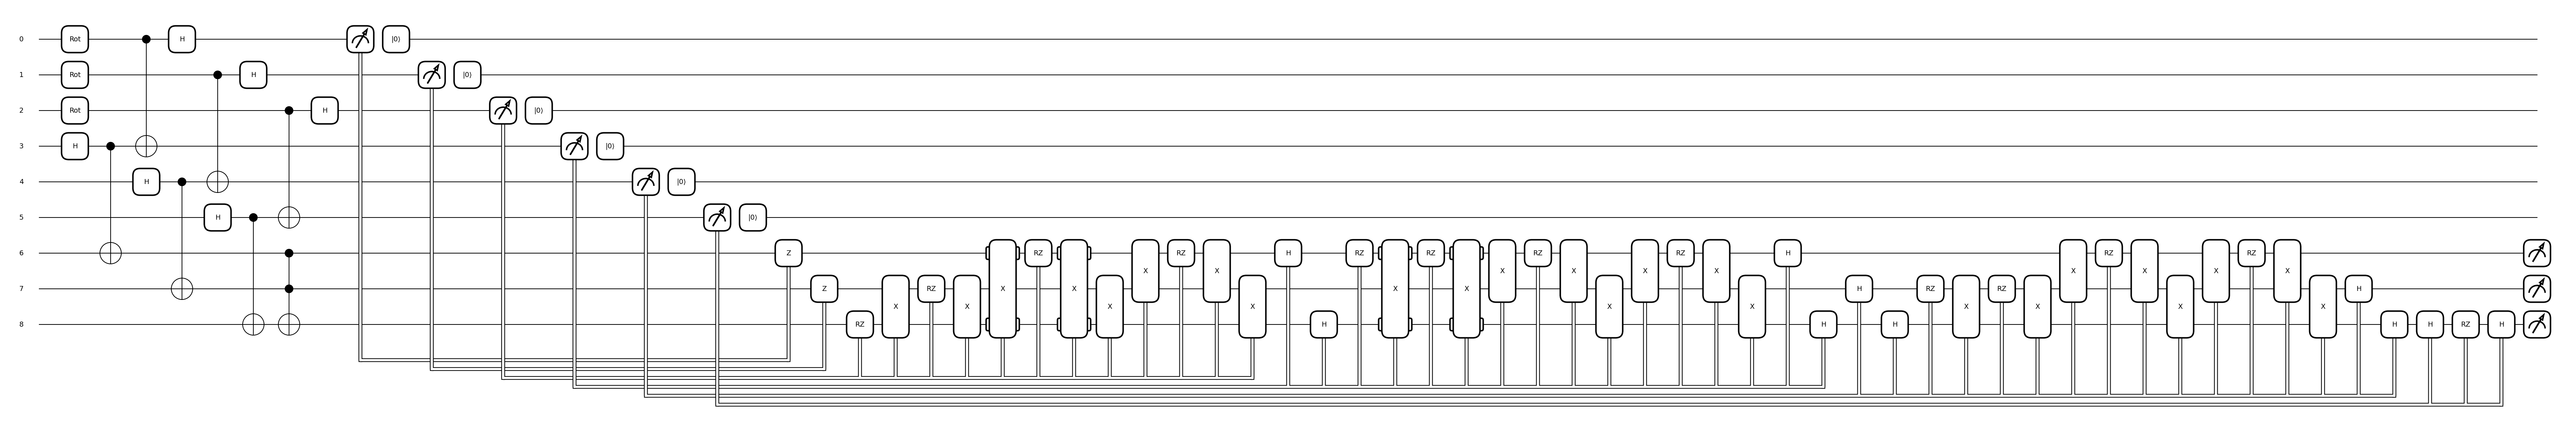

In [13]:
qml.draw_mpl(toffoli_teleportation)()

In [14]:
results = toffoli_teleportation()

dev = qml.device("default.qubit", wires=[0, 1, 2])
@qml.qnode(dev)
def toffoli_teleportation2():
    qml.Rot(values[0], values[1], values[2], wires=0)
    qml.Rot(values[3], values[4], values[5], wires=1)
    qml.Rot(values[6], values[7], values[8], wires=2)
    qml.Toffoli(wires=[0, 1, 2])
    return qml.density_matrix(wires=[0, 1, 2])

print(np.allclose(results, toffoli_teleportation2()))

True


## Measurements as solutions to challenges in NISQ devices

In the paper, we discuss:

1. Quantum hardware scalability problem: Circuit cutting$^1$
2. Quantum hardware error problem: Quantum error mitigation$^2$

#### Circuit cutting
<center>
<img src="figures/circuit_cutting_1.png" alt="circuit_cutting_1" width="400">
<img src="figures/circuit_cutting_2.png" alt="circuit_cutting_2" width="400">
</center>

* $^1$ *Circuit knitting with classical communication*. C. Piveteau, D. Sutter.
* $^2$ *Scalable tensor-network error mitigation for near-term quantum computing*. S. Filippov et al.

## Example on error mitigation$^1$ connecting to the IC-POVM example

<center>
<img src="figures/TEM.png" alt="gate_teleportation" width="800">
</center>

* $^1$ *Scalable tensor-network error mitigation for near-term quantum computing*. S. Filippov et al.

## Conclusion

In this work, we review measurement operation use cases and divide them into three categories:
1. Measurements in static quantum circuits
2. Measurements in dynamic quantum circuits
3. Measurements as solutions to challenges in NISQ devices

Making measurements as an active part of the algorithm rather than a passive readout method might improve the performance of our quantum algorithms and tackle problems such as integration with classical systems, scalability and error.

# Thank you!